In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Add, Activation, Lambda, Flatten
from tensorflow.keras.optimizers import Adam

# Custom polynomial activation function
def polynomial_activation(x):
    return x**4 + x**3 + x**2 + x + 1

# Normalize input data
def normalize_data(X):
    return (X - X.mean()) / X.std()

# Generate data
def generate_cosine_data(num_samples=1000):
    X = np.random.uniform(-5 * np.pi, 5 * np.pi, size=(num_samples, 1))
    y = np.cos(X)
    X = normalize_data(X)
    return X, y

def identity_block(x, filters):
    x_shortcut = x

    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = Activation(polynomial_activation)(x)
    #x = Activation('relu')(x)

    x = Dense(filters, kernel_initializer='he_normal')(x)
    x = Add()([x, x_shortcut])
    x = Activation(polynomial_activation)(x)
    #x = Activation('relu')(x)

    return x

# Modified ResNet-18 model
def resnet18():
    x_input = Input(shape=(1,))
    x = Dense(64, kernel_initializer='he_normal')(x_input)
    #x = Activation(polynomial_activation)(x)
    x = Activation('relu')(x)


    # for _ in range(4):
    #     x = identity_block(x, 64)

    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    model = Model(inputs=x_input, outputs=x)

    return model

In [2]:
# Train the model
X_train, y_train = generate_cosine_data()

# Create and compile the model
model = resnet18()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model.compile(optimizer=optimizer, loss='mse')

In [3]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 2s 1ms/step - loss: nan
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: nan
Epoch 13/100
32/32 [==============================] - 0s 1ms/step - loss:

7/7 [==============================] - 0s 827us/step


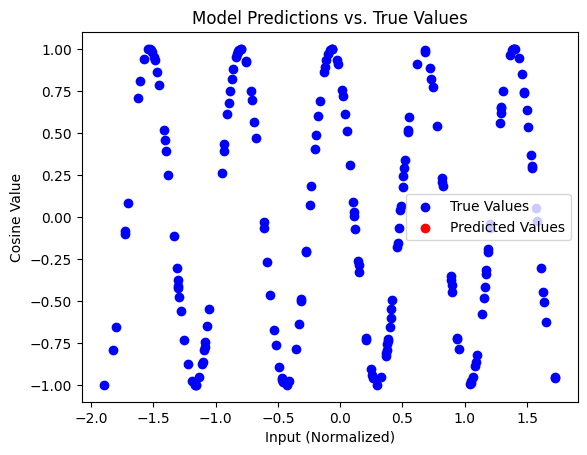

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Add, Activation, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Generate test data and make predictions
X_test, y_test = generate_cosine_data(num_samples=200)
y_pred = model.predict(X_test)

# Create a scatter plot
plt.scatter(X_test, y_test, c='blue', label='True Values')
plt.scatter(X_test, y_pred, c='red', label='Predicted Values')
plt.xlabel('Input (Normalized)')
plt.ylabel('Cosine Value')
plt.title('Model Predictions vs. True Values')
plt.legend()
plt.show()


PI


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def polynomial_activation(x, degree=1):
    if degree == 1:
        return x
    elif degree == 2:
        return x * x
    elif degree == 3:
        return x**3
    else:
        raise ValueError("Invalid degree specified, only 1st, 2nd and 3rd degree polynomials are supported.")

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def resnet_block(x, filters, activation_degree, rank=None):
    shortcut = x
    x = Dense(filters)(x)
    x = tf.keras.layers.Lambda(lambda y: polynomial_activation(y, degree=activation_degree))(x)

    if rank is not None:
        x = TensorDecompositionLayer(rank)(x)

    x = Dense(filters)(x)
    x = Add()([x, shortcut])
    return x

def build_model(input_shape, num_blocks, filters, activation_degree, rank=None):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_blocks):
        x = resnet_block(x, filters, activation_degree, rank)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

input_shape = (1,)
num_blocks = 3
filters = 16
activation_degree = 3  # Change to 1 for 1st degree polynomial, 2 for 2nd degree, and 3 for 3rd degree
rank = 4  # Tensor decomposition rank, set to None if you don't want to use tensor decomposition

model = build_model(input_shape, num_blocks, filters, activation_degree, rank)
model.compile(optimizer='adam', loss='mse')


In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
# lower_bound = -2 * np.pi
# upper_bound = 2 * np.pi
lower_bound = -10
upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 300

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/300
125/125 [==============================] - 1s 2ms/step - loss: 28691.6680 - val_loss: 3.7228
Epoch 2/300
125/125 [==============================] - 0s 1ms/step - loss: 2.2890 - val_loss: 2.0635
Epoch 3/300
125/125 [==============================] - 0s 1ms/step - loss: 1.8694 - val_loss: 1.7147
Epoch 4/300
125/125 [==============================] - 0s 1ms/step - loss: 1.5375 - val_loss: 1.4088
Epoch 5/300
125/125 [==============================] - 0s 1ms/step - loss: 1.2619 - val_loss: 1.1680
Epoch 6/300
125/125 [==============================] - 0s 1ms/step - loss: 1.0552 - val_loss: 0.9907
Epoch 7/300
125/125 [==============================] - 0s 1ms/step - loss: 0.9104 - val_loss: 0.8707
Epoch 8/300
125/125 [==============================] - 0s 1ms/step - loss: 0.8147 - val_loss: 0.7952
Epoch 9/300
125/125 [==============================] - 0s 1ms/step - loss: 0.7557 - val_loss: 0.7466
Epoch 10/300
125/125 [==============================] - 0s 1ms/step - loss: 0.7203 - va

Validation loss: 2.196891546191182e-05
32/32 [==============================] - 0s 592us/step


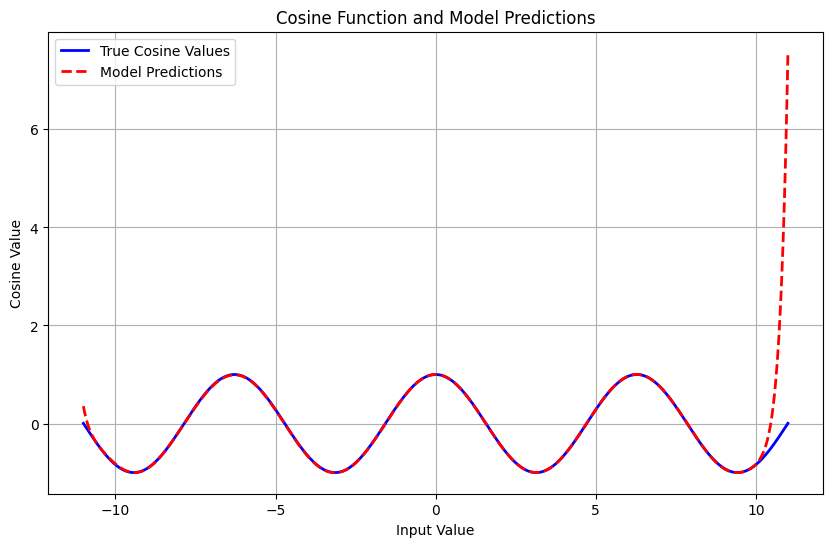

In [3]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(-11, 11, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class PolynomialLayer(Layer):
    def __init__(self, **kwargs):
        super(PolynomialLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.a = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        self.c = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(PolynomialLayer, self).build(input_shape)

    def call(self, x):
        return self.a + self.b * x + self.c * x**2

class FunctionCompositionLayer(Layer):
    def __init__(self, activation_1, activation_2, **kwargs):
        self.activation_1 = activation_1
        self.activation_2 = activation_2
        super(FunctionCompositionLayer, self).__init__(**kwargs)

    def call(self, x):
        x = self.activation_1(x)
        x = self.activation_2(x)
        return x

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def polynomial_activation(x, degree=1):
    if degree == 1:
        return x
    elif degree == 2:
        return x * x
    elif degree == 3:
        return x**3
    elif degree ==4:
        return x**4
    else:
        raise ValueError("Invalid degree specified, only 1st, 2nd and 3rd degree polynomials are supported.")

def resnet_block(x, filters, activation_1, activation_2, rank=None):
    shortcut = x
    x = Dense(filters)(x)
    x = PolynomialLayer()(x)
    x = FunctionCompositionLayer(activation_1, activation_2)(x)

    if rank is not None:
        x = TensorDecompositionLayer(rank)(x)

    x = Dense(filters)(x)
    x = Add()([x, shortcut])
    x = TensorDecompositionLayer(rank)(x)

    return x

def build_model(input_shape, num_blocks, filters, activation_1, activation_2, rank=None):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_blocks):
        x = resnet_block(x, filters, activation_1, activation_2, rank)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

input_shape = (1,)
num_blocks = 3
filters = 16
# activation_1 = tf.keras.activations.relu
activation_1 = lambda x: polynomial_activation(x, degree=2)
#activation_2 = tf.keras.activations.linear
activation_2 = lambda x: polynomial_activation(x, degree=1)

rank = 2

model = build_model(input_shape, num_blocks, filters, activation_1, activation_2, rank)
optimizer = Adam(learning_rate=0.00001) # Reduce learning rate
model.compile(optimizer='adam', loss='mse')


In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
#lower_bound = -2 * np.pi
#upper_bound = 2 * np.pi
lower_bound = -10
upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/200
125/125 [==============================] - 2s 3ms/step - loss: 0.5171 - val_loss: 0.4666
Epoch 2/200
125/125 [==============================] - 0s 1ms/step - loss: 0.4395 - val_loss: 0.4335
Epoch 3/200
125/125 [==============================] - 0s 1ms/step - loss: 0.4292 - val_loss: 0.4244
Epoch 4/200
125/125 [==============================] - 0s 1ms/step - loss: 0.4654 - val_loss: 0.4797
Epoch 5/200
125/125 [==============================] - 0s 1ms/step - loss: 0.4296 - val_loss: 0.4127
Epoch 6/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3862 - val_loss: 0.3437
Epoch 7/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3774 - val_loss: 0.3604
Epoch 8/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3421 - val_loss: 0.3356
Epoch 9/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3230 - val_loss: 0.3284
Epoch 10/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3231 - val_lo

Validation loss: 0.00230994401499629
32/32 [==============================] - 0s 654us/step


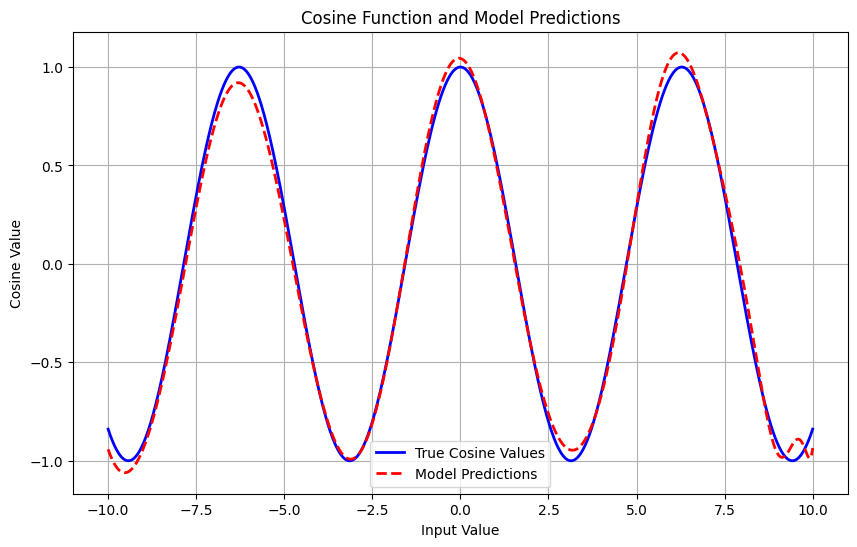

In [3]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()
